In [75]:
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

# generate a matrix using a negative binomial distribution
'''
def negbinom_mtx(num_genes, num_cells, mean_expression, dispersion, num_groups):
    counts = []
    group_means = [10, 75, 300]  # Different means for each group

    for cell in range(num_cells):
        # select mean for current group
        group_mean = random.choice(group_means)
        variance = group_mean + (dispersion * group_mean ** 2)  # variance based on dispersion
        r = round(group_mean ** 2 / (variance - group_mean)) # number of failures
        p = (variance - group_mean) / variance # prob of success

        gene_expression = []
        for _ in range(num_genes):
            # generate counts
            count = random.choices(range(1000), 
                                   weights=[math.comb(i + r - 1, i) * (p**r) * ((1 - p)**i) for i in range(1000)], 
                                   k=1)[0]
            gene_expression.append(count)
        
        counts.append(gene_expression)
    
    return pd.DataFrame(counts, index=[f'cell{j}' for j in range(num_cells)], columns=[f'gene{i}' for i in range(num_genes)])
'''

# poisson distribution
def poisson(lam):
    L = math.exp(-lam)
    k = 0
    p = 1
    while p > L:
        k += 1
        p *= random.random()
    return k - 1

def counts(num_genes, num_cells, num_groups):
    # parameters for different groups
    group_sizes = num_cells // num_groups
    counts = []
    group_labels = []

    # define distinct gene sets for each group
    genes_per_group = num_genes // num_groups

    # generate counts based on group
    for cell in range(num_cells):
        group_index = cell // group_sizes # determine group for current cell
        gene_expression = []

        # generate gene expression based on the group
        for gene in range(num_genes):
            if gene // genes_per_group == group_index:
                # high expression for the group's specific genes
                gene_expression.append(poisson(random.randint(20, 50)))
            else:
                # low expression for genes not specific to the group (noise)
                gene_expression.append(poisson(5)) 
            
        counts.append(gene_expression)
        group_labels.append(f'group {group_index + 1}') # assign group label based on group index
    
    # Create DataFrame
    df = pd.DataFrame(counts, index=[f'cell{j}' for j in range(num_cells)], columns=[f'gene{i}' for i in range(num_genes)])
    
    df['group'] = group_labels  # Add group column
    
    return df

# Generate counts matrix
counts_mtx = counts(100, 150, 3)
counts_mtx

,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,...,gene91,gene92,gene93,gene94,gene95,gene96,gene97,gene98,gene99,group
cell0,37,36,36,28,45,38,32,31,31,48,...,3,4,5,8,4,4,2,4,4,group 1
cell1,32,33,23,25,42,22,44,41,43,32,...,4,4,6,8,4,6,5,4,7,group 1
cell2,36,23,49,33,47,24,19,29,30,24,...,2,2,5,6,2,6,3,8,3,group 1
cell3,50,48,48,32,46,24,28,43,40,45,...,2,3,6,5,6,5,6,4,7,group 1
cell4,43,46,38,25,51,40,26,18,49,27,...,8,6,6,6,6,3,8,5,7,group 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell145,2,5,7,3,3,10,8,4,3,6,...,26,50,35,20,33,55,28,41,9,group 3
cell146,10,3,2,4,4,7,9,3,5,6,...,41,35,46,26,32,26,31,57,7,group 3
cell147,7,2,7,7,5,5,3,3,8,4,...,29,40,52,47,40,28,19,47,7,group 3
cell148,9,6,6,4,3,4,4,7,8,4,...,39,42,39,43,66,15,52,28,4,group 3


**Helper functions**

In [17]:
# compute mean of each row or column in the matrix (n_genes x n_cells)
def mtx_mean(matrix):
    mean_vals = []
    for row in matrix:
        mean_vals.append(sum(row) / len(row))
    return mean_vals

In [18]:
# center the matrix (mean subtraction)
def mtx_center(matrix, mean_vals):
    centered_matrix = []
    for i, row in enumerate(matrix):
        centered_row = [val - mean_vals[i] for val in row]
        centered_matrix.append(centered_row)
    return centered_matrix

In [19]:
# transpose
def transpose(matrix):
    return [[row[i] for row in matrix] for i in range(len(matrix[0]))]

In [20]:
# matrix multiplication
def mtx_multiply(A, B):
    result = [[sum(a * b for a, b in zip(A_row, B_col)) for B_col in zip(*B)] for A_row in A]
    return result

In [21]:
# singular value decomposition
def svd(matrix):
    # 1) transpose matrix
    matrix_t = transpose(matrix)
    
    # 2) compute matrix product (X^T * X)
    XTX = mtx_multiply(matrix_t, matrix)
    
    # 3) calculate eigenvalues and eigenvectors w/ power iteration
    eigenvalues, eigenvectors = power_iteration_multiple(XTX, k=len(matrix))
    
    # 4) compute the principal components (U matrix) from the right singular vectors
    U = mtx_multiply(matrix, transpose(eigenvectors))
    
    # 5) normalize each column vector in U to get orthonormal principal components
    for i in range(len(U[0])):
        norm = math.sqrt(sum([U[j][i]**2 for j in range(len(U))]))
        if norm != 0:  # Avoid division by zero
            for j in range(len(U)):
                U[j][i] = U[j][i] / norm
    
    return U, eigenvalues, eigenvectors

In [22]:
# find top eigenvectors/values (power iteration)
def power_iteration_multiple(matrix, k=2, num_simulations=1000):
    eigenvalues = []
    eigenvectors = []
    
    # iterate to find top k eigenvectors
    for _ in range(k):
        # initialize random vector with small non-zero values
        b_k = [0.1 for _ in range(len(matrix))]
        
        for _ in range(num_simulations):
            # calculate the matrix-by-vector product
            b_k1 = [sum(a * b for a, b in zip(row, b_k)) for row in matrix]
            
            # remove component projections from previously found eigenvectors
            for eigenvec in eigenvectors:
                proj = sum(eigenvec[i] * b_k1[i] for i in range(len(eigenvec)))
                b_k1 = [b_k1[i] - proj * eigenvec[i] for i in range(len(eigenvec))]
            
            # normalize the resulting vector
            norm = math.sqrt(sum(x**2 for x in b_k1))
            if norm == 0:  # if norm is zero, stop normalization
                break
            b_k = [x / norm for x in b_k1]
        
        # estimate the eigenvalue
        eigenvalue = sum(b_k[i] * sum(matrix[i][j] * b_k[j] for j in range(len(matrix))) for i in range(len(matrix)))
        
        # append eigenvalue and eigenvector
        eigenvalues.append(eigenvalue)
        eigenvectors.append(b_k)
    
    return eigenvalues, eigenvectors

In [44]:
# pca
def pca(counts_matrix, n_components=2):

    # drop non-numeric column & convert to list of lists
    data=counts_matrix.drop(columns='group').values.tolist()
    
    # 1) normalize (log-transform)
    norm_counts = [[math.log1p(val) for val in row] for row in data]
    
    # 2) center
    mean_vals = mtx_mean(norm_counts)
    centered_data = mtx_center(norm_counts, mean_vals)
    
    # 3) svd
    U, _, _ = svd(centered_data)
    
    # 4) select top n components
    reduced_data = [row[:n_components] for row in U]
    
    return reduced_data

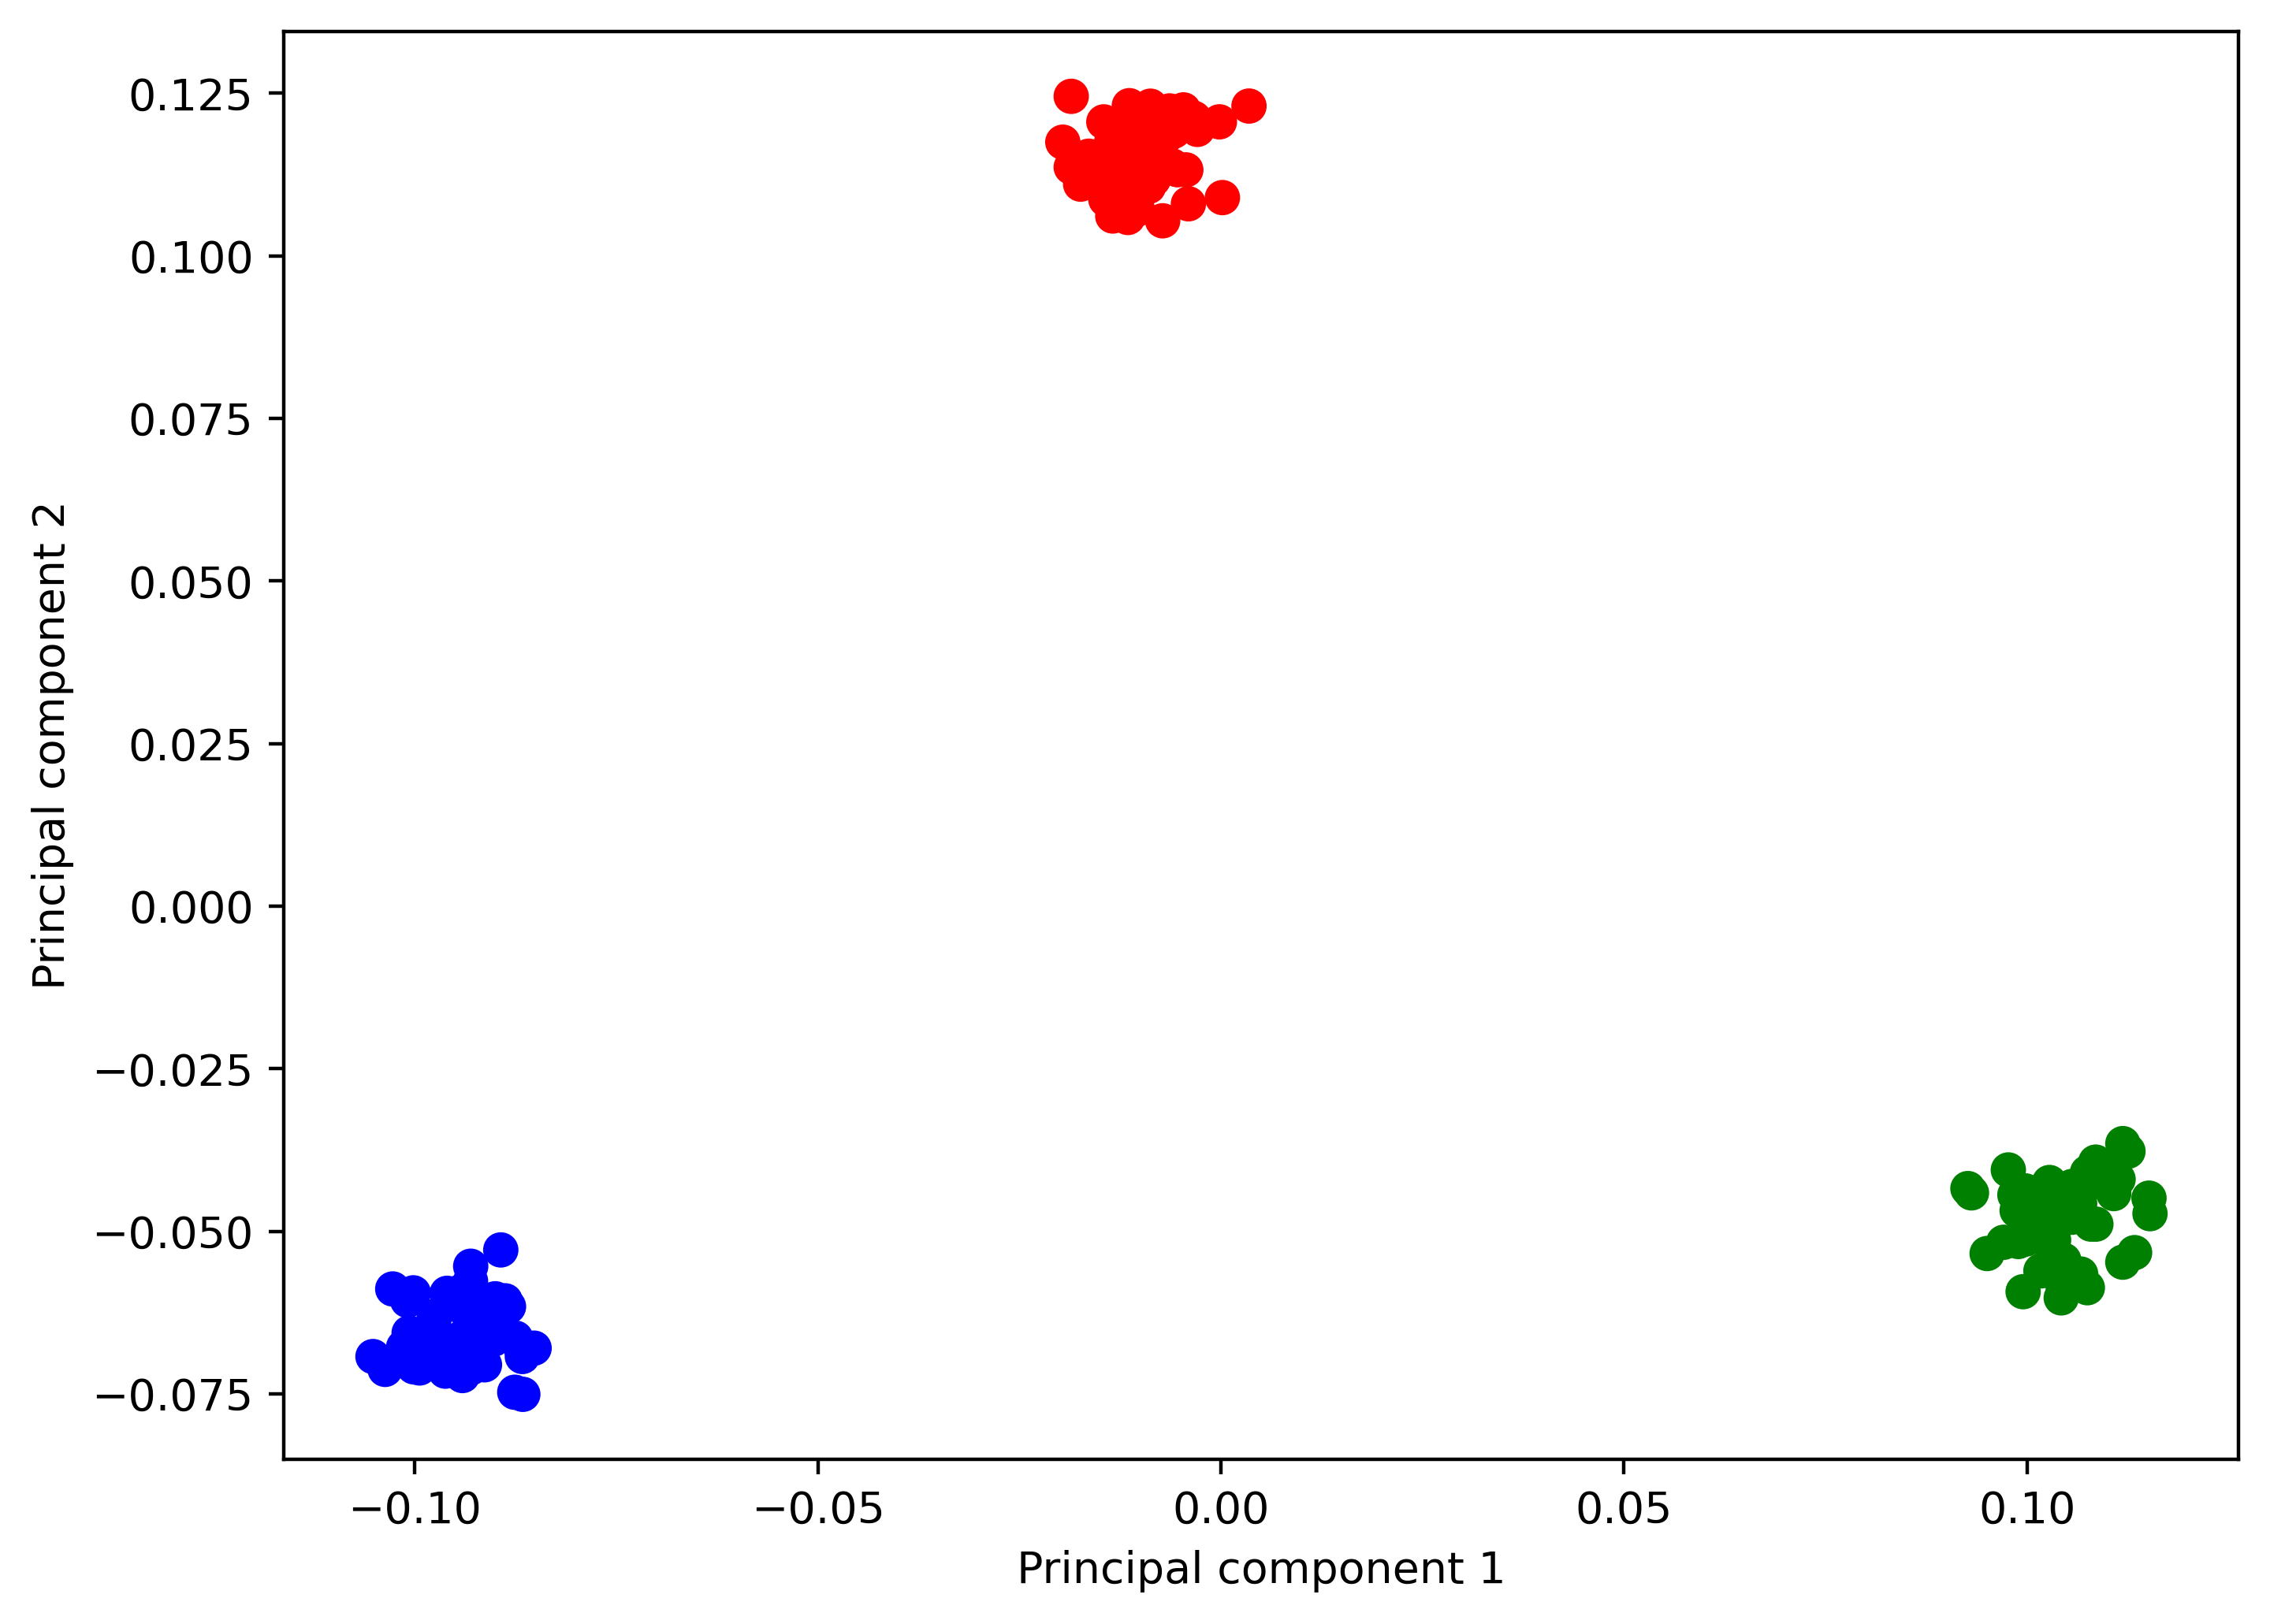

In [76]:
# project data
projected_data = pca(counts_mtx)

# for plotting
pc1 = [val[0] for val in projected_data]
pc2 = [val[1] for val in projected_data]

colours = {'group 1': 'red', 'group 2': 'green', 'group 3': 'blue'}
plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(pc1, pc2, s=50, c=[colours[label] for label in counts_mtx['group']])
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.grid(False)
plt.show()